In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tensorflow as tf
import tensorflow_probability as tfp
import gpytorch
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from scipy.stats import gamma, norm, beta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings





DECISION BOUNDARIES FOR LINUCB, NEURAL UCB AND GP THOMPSON SAMPLING

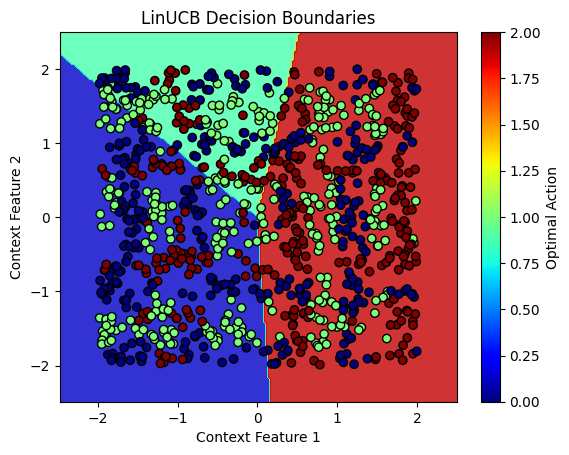

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(42)

# LinUCB class definition
class LinUCB:
    def __init__(self, n_actions, context_dim, alpha=.5):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha
        self.A = [np.identity(context_dim) for _ in range(n_actions)]  # d x d identity matrix
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]      # d x 1 zero vector

    def update(self, action, reward, context):
        context = np.array(context)
        self.A[action] += np.outer(context, context)
        self.b[action] += reward * context

    def predict(self, contexts):
        contexts = np.array(contexts)
        p = np.zeros((contexts.shape[0], self.n_actions))
        for i in range(contexts.shape[0]):
            for action in range(self.n_actions):
                A_inv = np.linalg.inv(self.A[action])
                theta = np.dot(A_inv, self.b[action])
                p[i, action] = np.dot(theta, contexts[i]) + self.alpha * np.sqrt(np.dot(contexts[i], np.dot(A_inv, contexts[i])))
        return p

# Step 1: Generate context features
np.random.seed(42)
n_samples = 1000
context = np.random.uniform(-2, 2, (n_samples, 2))  # 2D context features

# Step 2: Define reward functions for each action
def reward_action_1(x1, x2):
    return np.sin(2 * np.pi * x1) + np.cos(2 * np.pi * x2)

def reward_action_2(x1, x2):
    return np.sin(3 * np.pi * x1) + np.cos(1.5 * np.pi * x2)

def reward_action_3(x1, x2):
    return np.sin(1.5 * np.pi * x1) + np.cos(3 * np.pi * x2)

# Compute rewards for each action
rewards_1 = reward_action_1(context[:, 0], context[:, 1])
rewards_2 = reward_action_2(context[:, 0], context[:, 1])
rewards_3 = reward_action_3(context[:, 0], context[:, 1])

# Stack rewards and contexts
all_rewards = np.vstack([rewards_1, rewards_2, rewards_3]).T
optimal_actions = np.argmax(all_rewards, axis=1)

# Step 3: Train LinUCB on the data
linucb = LinUCB(n_actions=3, context_dim=2, alpha=0.5)
for i in range(n_samples):
    context_i = context[i]
    optimal_action_i = optimal_actions[i]
    reward_i = all_rewards[i, optimal_action_i]
    linucb.update(optimal_action_i, reward_i, context_i)

# Step 4: Predict optimal actions using LinUCB
predicted_actions = np.argmax(linucb.predict(context), axis=1)

# Step 5: Visualize the decision boundaries learned by LinUCB
x1_min, x1_max = context[:, 0].min() - 0.5, context[:, 0].max() + 0.5
x2_min, x2_max = context[:, 1].min() - 0.5, context[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                     np.linspace(x2_min, x2_max, 200))

Z = np.argmax(linucb.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8,cmap='jet')
plt.scatter(context[:, 0], context[:, 1], c=optimal_actions, edgecolor='k', marker='o', cmap='jet')
plt.title("LinUCB Decision Boundaries")
plt.xlabel('Context Feature 1')
plt.ylabel('Context Feature 2')
plt.colorbar(label='Optimal Action')
plt.show()


Epoch 100
Epoch 200
1250/1250 [==============================] - 3s 3ms/step


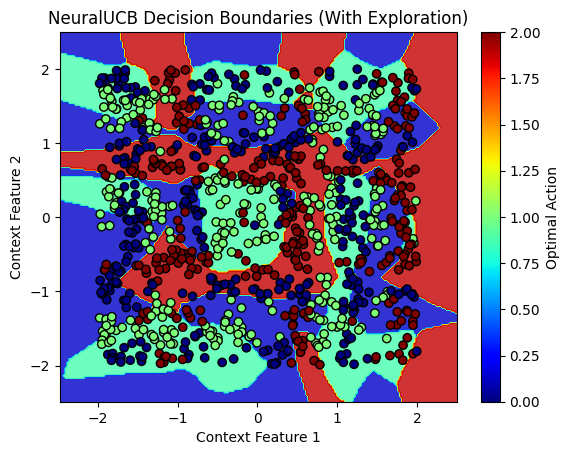

Epoch 100
Epoch 200
1250/1250 [==============================] - 3s 3ms/step


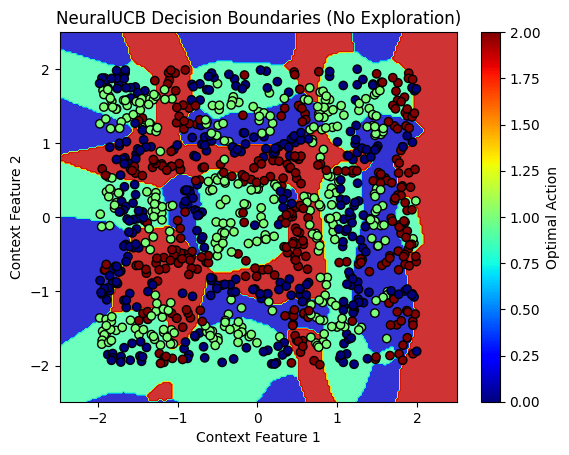

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler

# Define NeuralUCB class
class NeuralUCB:
    def __init__(self, n_actions, context_dim, alpha=0.5):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha
        
        # Define the neural network model
        self.model = Sequential([
            Dense(64, activation='relu', input_shape=(context_dim,)),
            Dense(64, activation='relu'),
            Dense(n_actions)
        ])
        
        self.model.compile(optimizer='adam', loss='mse')

    def update(self, contexts, rewards, actions):
        # Standardize the contexts
        scaler = StandardScaler()
        contexts = scaler.fit_transform(contexts)
        
        # Train the model with epoch counter callback
        epoch_counter = EpochCounter(every_n_epochs=100)
        self.model.fit(contexts, self.one_hot_encode(actions, self.n_actions), epochs=200, verbose=0, callbacks=[epoch_counter])

    def predict(self, contexts):
        contexts = StandardScaler().fit_transform(contexts)
        return self.model.predict(contexts)

    def one_hot_encode(self, actions, n_actions):
        return np.eye(n_actions)[actions]
    
class EpochCounter(Callback):
    def __init__(self, every_n_epochs=100):
        super(EpochCounter, self).__init__()
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n_epochs == 0:
            print(f'Epoch {epoch + 1}')

# Step 1: Generate context features
np.random.seed(42)
n_samples = 1000
context = np.random.uniform(-2, 2, (n_samples, 2))  # 2D context features

# Define reward functions for each action
def reward_action_1(x1, x2):
    return np.sin(2 * np.pi * x1) + np.cos(2 * np.pi * x2)

def reward_action_2(x1, x2):
    return np.sin(3 * np.pi * x1) + np.cos(1.5 * np.pi * x2)

def reward_action_3(x1, x2):
    return np.sin(1.5 * np.pi * x1) + np.cos(3 * np.pi * x2)

# Compute rewards for each action
rewards_1 = reward_action_1(context[:, 0], context[:, 1])
rewards_2 = reward_action_2(context[:, 0], context[:, 1])
rewards_3 = reward_action_3(context[:, 0], context[:, 1])

# Stack rewards and contexts
all_rewards = np.vstack([rewards_1, rewards_2, rewards_3]).T
optimal_actions = np.argmax(all_rewards, axis=1)

# Function to plot decision boundaries with adjustable exploration
def plot_decision_boundary(alpha=0.5, title_suffix=''):
    neuralucb = NeuralUCB(n_actions=3, context_dim=2, alpha=alpha)
    neuralucb.update(context, all_rewards, optimal_actions)
    
    # Create the meshgrid for plotting decision boundaries
    x1_min, x1_max = context[:, 0].min() - 0.5, context[:, 0].max() + 0.5
    x2_min, x2_max = context[:, 1].min() - 0.5, context[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 200), np.linspace(x2_min, x2_max, 200))
    
    # Predict using NeuralUCB
    Z = np.argmax(neuralucb.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='jet')
    plt.scatter(context[:, 0], context[:, 1], c=optimal_actions, edgecolor='k', marker='o', cmap='jet')
    plt.title(f"NeuralUCB Decision Boundaries {title_suffix}")
    plt.xlabel('Context Feature 1')
    plt.ylabel('Context Feature 2')
    plt.colorbar(label='Optimal Action')
    plt.show()

# Plot decision boundaries with high exploration (high alpha)
plot_decision_boundary(alpha=0.9, title_suffix='(With Exploration)')

# Plot decision boundaries with no exploration (low alpha)
plot_decision_boundary(alpha=0.0, title_suffix='(No Exploration)')


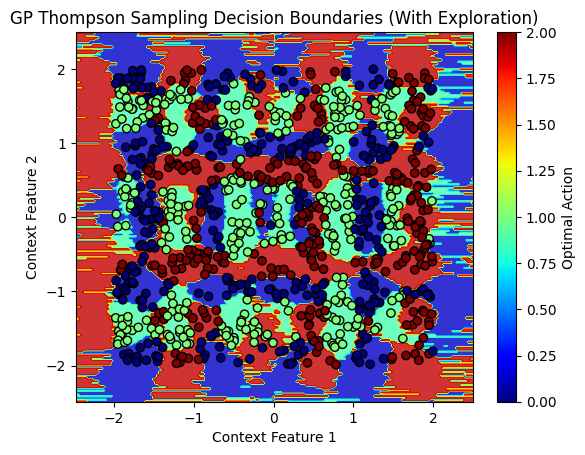

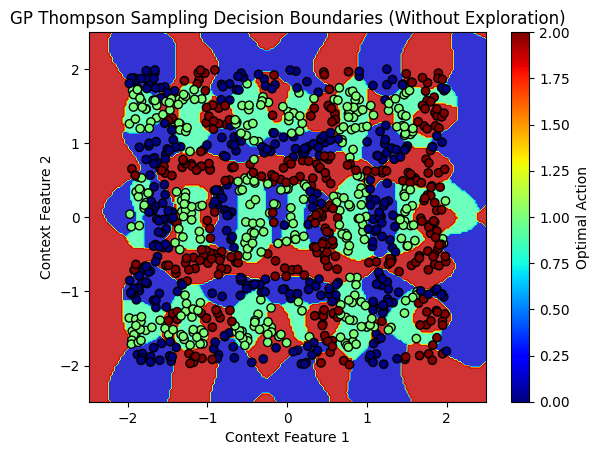

In [4]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, lengthscale=1.0, outputscale=1.0):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel(lengthscale=lengthscale)
        self.likelihood = likelihood
        self.scale = gpytorch.priors.NormalPrior(loc=0.0, scale=outputscale)
        self.covar_module.outputscale = self.scale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the GP Thompson Sampling class
class GPThompsonSampling:
    def __init__(self, n_actions, context_dim, num_samples=100, batch_size=10, lengthscale=1.0, outputscale=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.lengthscale = lengthscale
        self.outputscale = outputscale
        self.models = [None] * n_actions
        self.likelihoods = [gpytorch.likelihoods.GaussianLikelihood() for _ in range(n_actions)]

    def update(self, actions, rewards, contexts):
        contexts = torch.tensor(contexts, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)

        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum().item() == 0:
                continue

            X_train_action = contexts[indices]
            y_train_action = rewards[indices]

            self.models[action] = ExactGPModel(X_train_action, y_train_action, self.likelihoods[action], 
                                               lengthscale=self.lengthscale, outputscale=self.outputscale)
            self.models[action].train()
            optimizer = torch.optim.Adam(self.models[action].parameters(), lr=0.1)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihoods[action], self.models[action])

            for _ in range(50):  # Number of training epochs
                optimizer.zero_grad()
                output = self.models[action](X_train_action)
                loss = -mll(output, y_train_action)
                loss.backward()
                optimizer.step()

    def predict(self, context, exploration=True):
        context = torch.tensor(context, dtype=torch.float32)
        means = np.zeros((context.shape[0], self.n_actions))
        stddevs = np.zeros((context.shape[0], self.n_actions))

        for batch_start in range(0, context.shape[0], self.batch_size):
            context_batch = context[batch_start:batch_start + self.batch_size]
            for action in range(self.n_actions):
                if self.models[action] is None:
                    means[batch_start:batch_start + self.batch_size, action] = np.random.randn(context_batch.shape[0])
                    stddevs[batch_start:batch_start + self.batch_size, action] = np.ones(context_batch.shape[0])
                else:
                    self.models[action].eval()
                    if exploration:
                        gp_samples = self.sample_from_gp_posterior(self.models[action], context_batch, self.num_samples)
                        means[batch_start:batch_start + self.batch_size, action] = gp_samples.mean(dim=0).numpy()
                    else:
                        with torch.no_grad():
                            posterior = self.models[action](context_batch)
                            means[batch_start:batch_start + self.batch_size, action] = posterior.mean.numpy()

        return means

    def sample_from_gp_posterior(self, model, context, num_samples):
        with torch.no_grad():
            posterior = model(context)
            samples = posterior.sample(sample_shape=torch.Size([num_samples]))
        return samples

# Simulate data
n_samples = 1000
context = np.random.uniform(-2, 2, (n_samples, 2))  # 2D context features

def reward_action_1(x1, x2):
    return np.sin(2 * np.pi * x1) + np.cos(2 * np.pi * x2)

def reward_action_2(x1, x2):
    return np.sin(3 * np.pi * x1) + np.cos(1.5 * np.pi * x2)

def reward_action_3(x1, x2):
    return np.sin(1.5 * np.pi * x1) + np.cos(3 * np.pi * x2)

rewards_1 = reward_action_1(context[:, 0], context[:, 1])
rewards_2 = reward_action_2(context[:, 0], context[:, 1])
rewards_3 = reward_action_3(context[:, 0], context[:, 1])

all_rewards = np.vstack([rewards_1, rewards_2, rewards_3]).T
optimal_actions = np.argmax(all_rewards, axis=1)

# Convert data for GP Thompson Sampling
actions = optimal_actions
rewards = all_rewards[np.arange(n_samples), optimal_actions]

# Train GP Thompson Sampling on the data
gp_ts = GPThompsonSampling(n_actions=3, context_dim=2, num_samples=10, batch_size=100, lengthscale=1.0, outputscale=1.0)
gp_ts.update(actions, rewards, context)

# Create the meshgrid for plotting decision boundaries
x1_min, x1_max = context[:, 0].min() - 0.5, context[:, 0].max() + 0.5
x2_min, x2_max = context[:, 1].min() - 0.5, context[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 200), np.linspace(x2_min, x2_max, 200))

# Function to plot decision boundaries
def plot_decision_boundary(exploration=True):
    means_grid = gp_ts.predict(np.c_[xx.ravel(), yy.ravel()], exploration=exploration)
    Z = np.argmax(means_grid, axis=1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap='jet')
    plt.scatter(context[:, 0], context[:, 1], c=optimal_actions, edgecolor='k', marker='o', cmap='jet')
    plt.title(f"GP Thompson Sampling Decision Boundaries ({'With Exploration' if exploration else 'Without Exploration'})")
    plt.xlabel('Context Feature 1')
    plt.ylabel('Context Feature 2')
    plt.colorbar(label='Optimal Action')
    plt.show()

# Plot decision boundaries with and without exploration
plot_decision_boundary(exploration=True)   # With exploration
plot_decision_boundary(exploration=False)  # Without exploration


In [ ]:
CONTEXTUAL BANDITS (LINUCB, GP THOMPSON SAMPLING, BAYES NEURAL NETWORK THOMPSON SAMPLING) SIMULATION AND PERFORMANCE

In [5]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Call the seed setting function
set_seed(42)



def non_linear_reward_function(features, action, theta):
    if features.shape[1] != len(theta[action]):
        raise ValueError("Length of theta must match the number of features.")
    
    term1 = np.sin(np.dot(features, theta[action]))
    term2 = np.prod(np.cos(features), axis=1)
    term3 = np.sum(np.sin(features), axis=1)
    
    return term1 * term2 * term3 


## non stationary reward function
def non_linear_reward_function2(features, action, theta, context_sensitivity=0.1):
    if features.shape[1] != len(theta[action]):
        raise ValueError("Length of theta must match the number of features.")
    
    # Introduce variability based on context
    context_effect = np.mean(features, axis=1) * context_sensitivity
    
    term1 = np.sin(np.dot(features, theta[action]))
    term2 = np.prod(np.cos(features), axis=1)
    term3 = np.sum(np.sin(features), axis=1)
    
    return term1 * term2 * term3 + context_effect




# Define the data generation function
def generate_data(total_samples, n_actions, context_dim, true_theta, noise_level=0.1):
    X = np.random.rand(total_samples, context_dim)
    rewards = np.zeros((total_samples, n_actions))
    for action in range(n_actions):
        rewards[:, action] = non_linear_reward_function(X, action, true_theta) + noise_level * np.random.randn(total_samples)
    optimal_actions = np.argmax(rewards, axis=1)
    return X, optimal_actions, rewards

# Define the data generation and splitting function
def generate_data_and_split(total_samples, n_actions, context_dim, true_theta, noise_level=0.1):
    X, optimal_actions, rewards = generate_data(total_samples, n_actions, context_dim, true_theta, noise_level)
    
    split_index = int(total_samples * 0.8)
    X_train = X[:split_index]
    historical_actions = generate_actions(split_index, n_actions)
    historical_rewards = rewards[:split_index]
    
    X_val = X[split_index:]
    optimal_actions_val = optimal_actions[split_index:]
    rewards_val = rewards[split_index:]
    
    return X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val

# Function to generate actions from a normal distribution and clip them to valid action range
def generate_actions(total_samples, n_actions):
    return np.clip(np.random.normal(loc=n_actions/2, scale=n_actions/6, size=total_samples), 0, n_actions-1).astype(int)


def plot_feature_vs_rewards(X, rewards, feature_idx, dot_size=20):
    """
    Plots a single feature against the rewards for all actions.
    X: Features array of shape (total_samples, context_dim)
    rewards: Rewards array of shape (total_samples, n_actions)
    feature_idx: Index of the feature to plot (e.g., 0 for Feature 1)
    dot_size: Size of the dots in the scatter plot (default is 20)
    """
    plt.figure(figsize=(10, 5))
    feature_values = X[:, feature_idx]
    
    for action in range(rewards.shape[1]):  # Loop over each action
        plt.scatter(feature_values, rewards[:, action], label=f'Action {action}', alpha=0.5, s=dot_size)
    
    plt.xlabel(f'Feature {feature_idx + 1}')  # Adjust for 1-based indexing in the title
    plt.ylabel('Reward')
    plt.title(f'Feature {feature_idx + 1} vs Rewards for All Actions')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot the distribution of actions
def plot_action_distribution(n_actions, actions):
    plt.figure(figsize=(10, 2))
    plt.hist(actions, bins=np.arange(n_actions + 1) - 0.5, edgecolor='black', alpha=0.7)
    plt.title('Historical Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.xticks(range(n_actions))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    


# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, lengthscale=1.0, outputscale=1.0):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, lengthscale=lengthscale)
        )
        self.covar_module.outputscale = outputscale

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Define the GP Thompson Sampling class
class GPThompsonSampling:
    def __init__(self, n_actions, context_dim, num_samples=10, lengthscale=1.0, outputscale=1.0):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.num_samples = num_samples
        self.lengthscale = lengthscale
        self.outputscale = outputscale
        self.models = [None] * n_actions
        self.likelihoods = [gpytorch.likelihoods.GaussianLikelihood() for _ in range(n_actions)]

    def update(self, actions, rewards, contexts):
        contexts = torch.tensor(contexts, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)

        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum().item() == 0:
                continue

            X_train_action = contexts[indices]
            y_train_action = rewards[indices, action]

            # Initialize and train the GP model for this action
            self.models[action] = ExactGPModel(X_train_action, y_train_action, self.likelihoods[action], 
                                               lengthscale=self.lengthscale, outputscale=self.outputscale)
            self.models[action].train()
            optimizer = torch.optim.Adam(self.models[action].parameters(), lr=0.1)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihoods[action], self.models[action])

            for _ in range(100):  # Number of training epochs
                optimizer.zero_grad()
                output = self.models[action](X_train_action)

                if y_train_action.dim() > 1:
                    y_train_action = y_train_action.squeeze(-1)

                loss = -mll(output, y_train_action)
                
                if loss.numel() != 1:
                    raise ValueError(f"Expected scalar loss, but got shape {loss.shape}")

                loss.backward()
                optimizer.step()

    def predict(self, context):
        context = torch.tensor(context, dtype=torch.float32)
        means = np.zeros((context.shape[0], self.n_actions))
        stddevs = np.zeros((context.shape[0], self.n_actions))
        for action in range(self.n_actions):
            if self.models[action] is None:
                means[:, action] = np.random.randn(context.shape[0])
                stddevs[:, action] = np.ones(context.shape[0])
            else:
                self.models[action].eval()
                gp_samples = self.sample_from_gp_posterior(self.models[action], context, self.num_samples)
                means[:, action] = gp_samples.mean(dim=0).numpy()
                stddevs[:, action] = gp_samples.std(dim=0).numpy()
        return means, stddevs

    def sample_from_gp_posterior(self, model, context, num_samples):
        with torch.no_grad():
            posterior = model(context)
            samples = posterior.sample(sample_shape=torch.Size([num_samples]))
        return samples
    
    
# Define the Bayesian Neural Network (BNN) model using TensorFlow Probability
class BayesianNN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim, num_samples):
        super(BayesianNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_samples = num_samples

        self.hidden = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.out = tf.keras.layers.Dense(output_dim)

        self.prior = tfp.layers.default_mean_field_normal_fn()
        self.posterior = tfp.layers.default_mean_field_normal_fn()

    def call(self, x):
        x = self.hidden(x)
        x = self.out(x)
        return x

    def build_bayesian_layers(self):
        self.hidden_bnn = tfp.layers.DenseVariational(
            units=self.hidden_dim,
            make_posterior_fn=self.posterior,
            make_prior_fn=self.prior,
            activation='relu'
        )
        self.out_bnn = tfp.layers.DenseVariational(
            units=self.output_dim,
            make_posterior_fn=self.posterior,
            make_prior_fn=self.prior
        )

    def train_step(self, data):
        contexts, rewards, actions = data
        with tf.GradientTape() as tape:
            logits = self(contexts, training=True)

            # Define the scale_diag to match the logits' shape
            scale_diag = tf.ones_like(logits)
            
            # Use MultivariateNormalDiag with the appropriate scale_diag shape
            distribution = tfp.distributions.MultivariateNormalDiag(loc=logits, scale_diag=scale_diag)
            log_likelihood = tf.reduce_sum(distribution.log_prob(rewards))
            loss = -log_likelihood

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        contexts, rewards, actions = data
        logits = self(contexts, training=False)

        scale_diag = tf.ones_like(logits)
        distribution = tfp.distributions.MultivariateNormalDiag(loc=logits, scale_diag=scale_diag)
        log_likelihood = tf.reduce_sum(distribution.log_prob(rewards))
        loss = -log_likelihood
        return {"loss": loss}

    def predict(self, contexts):
        means = np.zeros((contexts.shape[0], self.output_dim))
        stddevs = np.zeros((contexts.shape[0], self.output_dim))

        # Sample from the Bayesian model's posterior
        for _ in range(self.num_samples):
            logits = self(contexts, training=False)
            means += logits.numpy()
            stddevs += np.std(logits.numpy(), axis=0)  # Approximate std deviation

        means /= self.num_samples
        stddevs /= self.num_samples
        return means, stddevs
    
    def thompson_sampling(self, contexts):
        # For Thompson Sampling, we sample from the BNN's posterior once per context
        logits = self(contexts, training=False).numpy()  # This is a single sample

        # Select the action with the highest sampled logit (optimal action)
        selected_actions = np.argmax(logits, axis=1)

        return selected_actions, logits


    

# Ridge regression model class
class RidgeRegression:
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.models = [Ridge(alpha=1.0) for _ in range(n_actions)]

    def fit(self, contexts, rewards, actions):
        contexts = np.array(contexts)
        rewards = np.array(rewards)
        actions = np.array(actions)
        for action in range(self.n_actions):
            indices = (actions == action)
            if indices.sum() > 0:
                X_train_action = contexts[indices]
                y_train_action = rewards[indices, action]
                self.models[action].fit(X_train_action, y_train_action)

    def predict(self, contexts):
        contexts = np.array(contexts)
        predictions = np.zeros((contexts.shape[0], self.n_actions))
        for action in range(self.n_actions):
            predictions[:, action] = self.models[action].predict(contexts)
        return predictions

# Random strategy class
class RandomStrategy:
    def __init__(self, n_actions):
        self.n_actions = n_actions

    def predict(self, contexts):
        contexts = np.array(contexts)
        return np.random.randint(0, self.n_actions, size=(contexts.shape[0],))
    
# Function to plot GP Thompson Sampling predictions with uncertainty
def plot_bnn_uncertainty(contexts, means, stddevs, num_samples=10):
    x = np.arange(contexts.shape[0])
    plt.figure(figsize=(12, 2))
    plt.plot(x, means[:, 0], label='BNN Thompson Sampling Mean Predictions')
    plt.fill_between(x, means[:, 0] - 1.96 * stddevs[:, 0], means[:, 0] + 1.96 * stddevs[:, 0], color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.title('BNN Thompson Sampling Predictions with Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Mean Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_bnn_predictions_with_uncertainty(contexts, means, stddevs, n_actions):
    plt.figure(figsize=(12, 2))
    
    # Plot each action's predictions with uncertainty
    for action in range(n_actions):
        x = np.arange(contexts.shape[0])
        plt.errorbar(x, means[:, action], yerr=1.96 * stddevs[:, action], fmt='o', label=f'Action {action}')
    
    plt.title('BNN Thompson Sampling Predictions with Uncertainty')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Reward')
    plt.legend()
    plt.grid(True)
    plt.show()
    

    

# Updated LinUCB class
class LinUCB:
    def __init__(self, n_actions, context_dim, alpha=0.5):
        self.n_actions = n_actions
        self.context_dim = context_dim
        self.alpha = alpha
        self.A = [np.identity(context_dim) for _ in range(n_actions)]  # d x d identity matrix
        self.b = [np.zeros(context_dim) for _ in range(n_actions)]      # d x 1 zero vector

    def update(self, action, reward, context):
        context = np.array(context)
        self.A[action] += np.outer(context, context)
        self.b[action] += reward * context

    def predict(self, contexts):
        contexts = np.array(contexts)
        p = np.zeros((contexts.shape[0], self.n_actions))
        for i in range(contexts.shape[0]):
            for action in range(self.n_actions):
                A_inv = np.linalg.inv(self.A[action])
                theta = np.dot(A_inv, self.b[action])
                p[i, action] = np.dot(theta, contexts[i]) + self.alpha * np.sqrt(np.dot(contexts[i], np.dot(A_inv, contexts[i])))
        return p
    
    
# Function to plot comparison of optimal actions and GP Thompson Sampling actions
def plot_optimal_vs_gp_ts(optimal_actions, gp_ts_preds):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(gp_ts_preds)) + 2) - 0.5
    
    # Plot histograms for optimal actions and GP TS predictions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(gp_ts_preds, bins=bins, edgecolor='black', alpha=0.5, label='GP Thompson Sampling Actions')
    
    plt.title('Comparison of Optimal Actions vs GP Thompson Sampling Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_optimal_vs_linucb(optimal_actions, linucb_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(linucb_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(linucb_actions, bins=bins, edgecolor='black', alpha=0.5, label='LinUCB Actions')
    
    plt.title('Comparison of Optimal Actions vs LinUCB Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_optimal_vs_bnn(optimal_actions, bnn_actions):
    plt.figure(figsize=(12, 1))
    
    # Ensure bins range covers all possible actions, including action 0
    bins = np.arange(0, max(np.max(optimal_actions), np.max(bnn_actions)) + 2) - 0.5
    
    # Plot histograms for optimal actions and LinUCB actions with original color formatting
    plt.hist(optimal_actions, bins=bins, edgecolor='black', alpha=0.5, label='Optimal Actions')
    plt.hist(bnn_actions, bins=bins, edgecolor='black', alpha=0.5, label='BNN Thompson Sampling Actions')
    
    plt.title('Comparison of Optimal Actions vs BNN Thompson Sampling Actions')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    
    # Set x-ticks for all possible actions, including 0
    plt.xticks(range(int(bins.min() + 0.5), int(bins.max() + 0.5)))
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()





def run_backtest(total_samples, n_actions, context_dim, true_theta, noise_level=0.1, num_samples=10, lengthscale=1.0, outputscale=1.0, epochs=20):
    
    X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
        total_samples, n_actions, context_dim, true_theta, noise_level)
    
    
    # GP Thompson Sampling
    gp_ts_model = GPThompsonSampling(n_actions, context_dim, num_samples, lengthscale, outputscale)
    gp_ts_model.update(historical_actions, historical_rewards, X_train)
    gp_ts_means, gp_ts_stddevs = gp_ts_model.predict(X_val)
    gp_ts_preds = np.argmax(gp_ts_means, axis=1)
    
    # Ridge Regression
    ridge_model = RidgeRegression(n_actions)
    ridge_model.fit(X_train, historical_rewards, historical_actions)
    ridge_preds = ridge_model.predict(X_val)
    ridge_preds = np.argmax(ridge_preds, axis=1)
    
    # LinUCB
    lin_UCB_model = LinUCB(n_actions, context_dim, alpha=0.5)
    for i in range(len(historical_actions)):
        lin_UCB_model.update(historical_actions[i], historical_rewards[i, historical_actions[i]], X_train[i])
    lin_UCB_preds = lin_UCB_model.predict(X_val)
    lin_UCB_preds = np.argmax(lin_UCB_preds, axis=1)
    
    # Random Strategy
    random_strategy = RandomStrategy(n_actions)
    random_preds = random_strategy.predict(X_val)
    
    
   
    # Bayesian Neural Network
    # Initialize the Bayesian Neural Network model
    hidden_dim = 40
    num_samples = 10
    bnn_model = BayesianNN(input_dim=context_dim, hidden_dim=hidden_dim, output_dim=n_actions, num_samples=num_samples)
    bnn_model.build_bayesian_layers()  # Build Bayesian layers
    
    # Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    bnn_model.optimizer = optimizer
    # Update the model with training data
    # Train the model
    dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), historical_rewards.astype(np.float32), historical_actions.astype(np.int32)))
    dataset = dataset.batch(32)
    for epoch in range(epochs):
        for step, batch_data in enumerate(dataset):
            loss = bnn_model.train_step(batch_data)
        if epoch % 10 == 0:
                print(f"Epoch {epoch}, Step {step}: Loss = {loss['loss'].numpy()}")
                
    bnn_means, bnn_stddevs = bnn_model.predict(X_val)
    bnn_preds, sampled_logits = bnn_model.thompson_sampling(X_val)
    
    
    
    
    
    all_true_rewards = np.zeros((X_val.shape[0], n_actions))
    for action in range(n_actions):
        all_true_rewards[:, action] = non_linear_reward_function(X_val, action, true_theta)
    
    true_rewards = np.max(all_true_rewards, axis=1)
    
    gp_ts_rewards = np.array([all_true_rewards[i, gp_ts_preds[i]] for i in range(len(gp_ts_preds))])
    ridge_rewards = np.array([all_true_rewards[i, ridge_preds[i]] for i in range(len(ridge_preds))])
    random_rewards = np.array([all_true_rewards[i, random_preds[i]] for i in range(len(random_preds))])
    lin_UCB_rewards = np.array([all_true_rewards[i, lin_UCB_preds[i]] for i in range(len(lin_UCB_preds))])
    bnn_rewards = np.array([all_true_rewards[i, bnn_preds[i]] for i in range(len(bnn_preds))])
    
    plt.figure(figsize=(12, 5))
    plt.plot(np.cumsum(true_rewards), label='Optimal Policy', linestyle='--')
    plt.plot(np.cumsum(bnn_rewards), label='BNN Thompson Sampling')
    plt.plot(np.cumsum(gp_ts_rewards), label='GP Thompson Sampling')
    plt.plot(np.cumsum(lin_UCB_rewards), label='Lin_UCB Strategy')
    plt.plot(np.cumsum(ridge_rewards), label='Ridge Regression')
    plt.plot(np.cumsum(random_rewards), label='Random Strategy')
    
  
    plt.title('Cumulative Rewards')
    plt.xlabel('Sample Index')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()


    # Plot GP Thompson Sampling predictions with uncertainty
    plot_bnn_uncertainty(X_val, bnn_means, bnn_stddevs)
    plot_bnn_predictions_with_uncertainty(X_val, bnn_means, bnn_stddevs, n_actions)
    plot_optimal_vs_bnn(optimal_actions_val, bnn_preds)
    plot_optimal_vs_gp_ts(optimal_actions_val, gp_ts_preds)
    plot_optimal_vs_linucb(optimal_actions_val, lin_UCB_preds)
    
    
    print(f"BNN Thompson Sampling Accuracy: {accuracy_score(optimal_actions_val, bnn_preds):.4f}")
    print(f"BNN Thompson Sampling F1 Score: {f1_score(optimal_actions_val, bnn_preds, average='weighted'):.4f}")

    print(f"GP Thompson Sampling Accuracy: {accuracy_score(optimal_actions_val, gp_ts_preds):.4f}")
    print(f"GP Thompson Sampling F1 Score: {f1_score(optimal_actions_val, gp_ts_preds, average='weighted'):.4f}")
    
    print(f"LinUCB Accuracy: {accuracy_score(optimal_actions_val, lin_UCB_preds):.4f}")
    print(f"LinUCB F1 Score: {f1_score(optimal_actions_val, lin_UCB_preds, average='weighted'):.4f}")
    
 
    print(f"Ridge Regression Accuracy: {accuracy_score(optimal_actions_val, ridge_preds):.4f}")
    print(f"Ridge Regression F1 Score: {f1_score(optimal_actions_val, ridge_preds, average='weighted'):.4f}")

    print(f"Random Strategy Accuracy: {accuracy_score(optimal_actions_val, random_preds):.4f}")
    print(f"Random Strategy F1 Score: {f1_score(optimal_actions_val, random_preds, average='weighted'):.4f}")

    

# Example usage
total_samples = 1000
n_actions = 3
context_dim = 20
noise_level = 0.1

def initialize_true_theta(n_actions, context_dim):
        return [np.random.randn(context_dim) for _ in range(n_actions)]

true_theta = initialize_true_theta(n_actions, context_dim)

X_train, X_val, historical_actions, historical_rewards, optimal_actions_val, rewards_val = generate_data_and_split(
        total_samples, n_actions, context_dim, true_theta, noise_level)


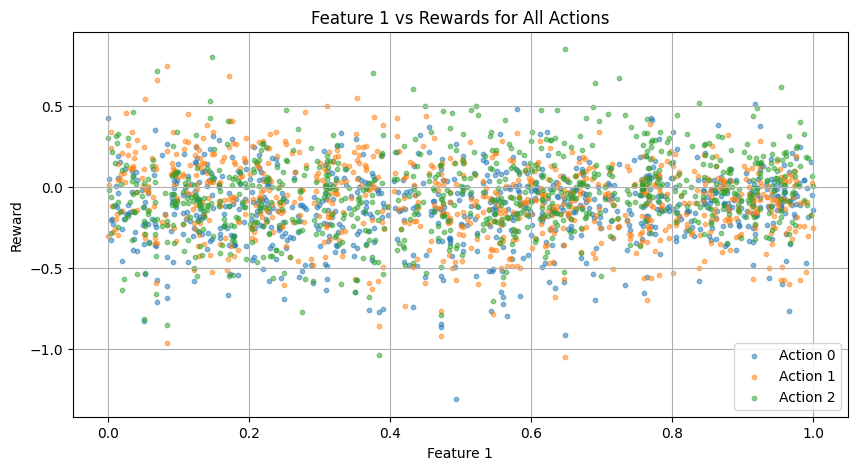

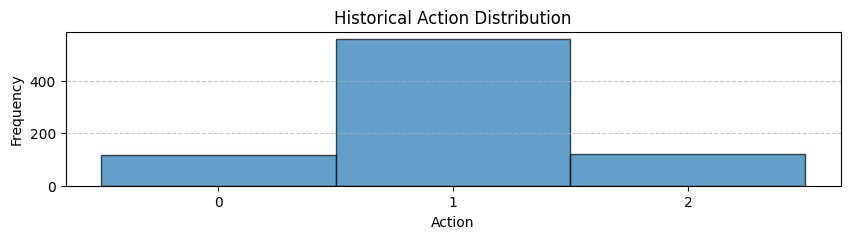

In [6]:
# Plot for Feature 1 (i.e., feature_idx = 0)
plot_feature_vs_rewards(X_train, historical_rewards, feature_idx=0, dot_size=10)
plot_action_distribution(n_actions, historical_actions)

Epoch 0, Step 24: Loss = 91.49507141113281
Epoch 10, Step 24: Loss = 89.8334732055664
Epoch 20, Step 24: Loss = 89.5254135131836


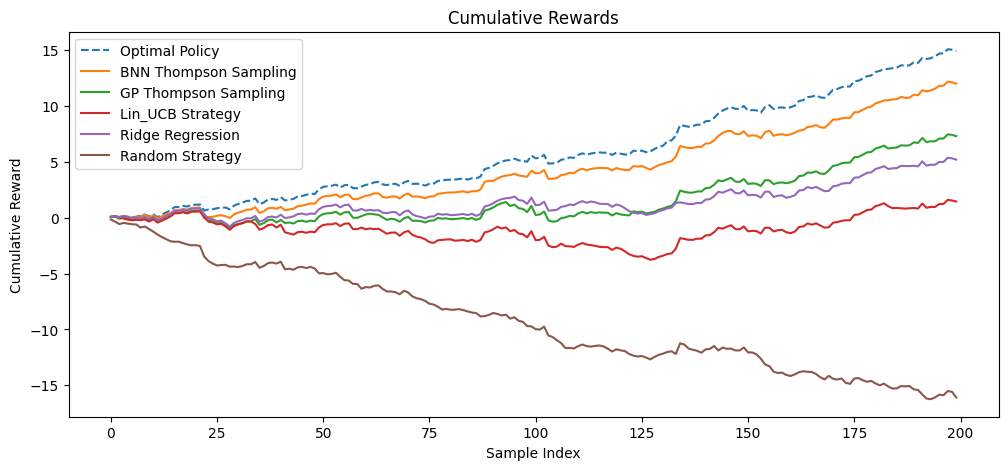

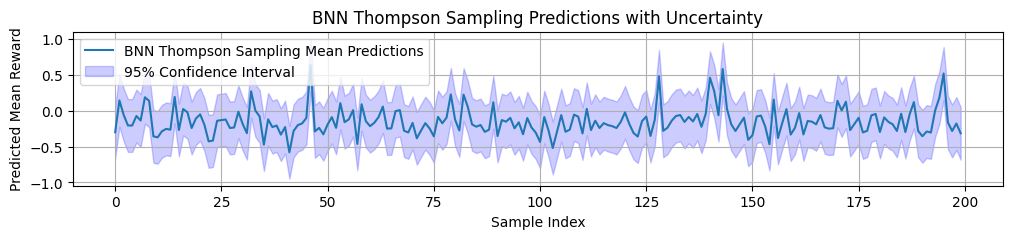

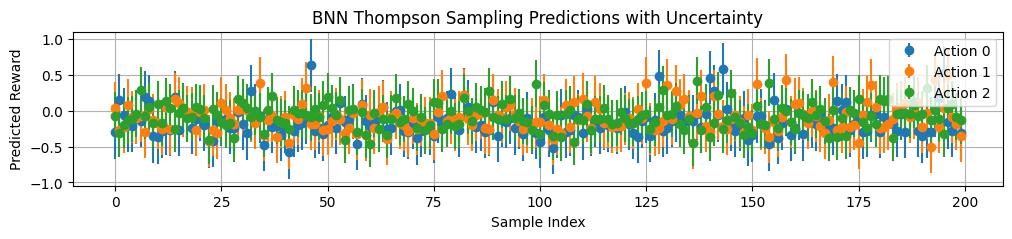

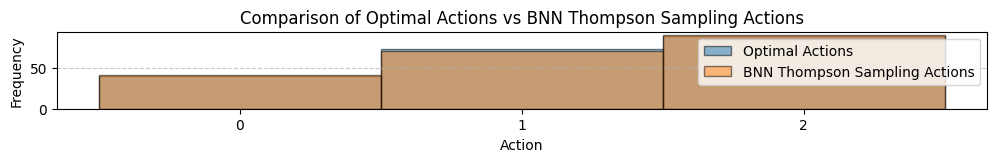

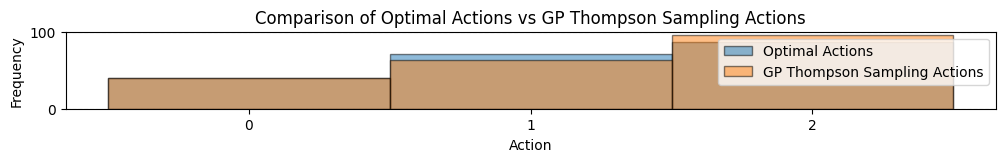

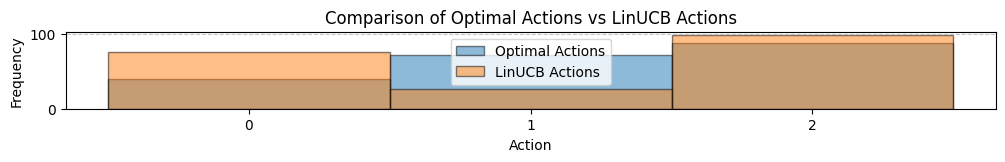

BNN Thompson Sampling Accuracy: 0.7000
BNN Thompson Sampling F1 Score: 0.7001
GP Thompson Sampling Accuracy: 0.6100
GP Thompson Sampling F1 Score: 0.6078
LinUCB Accuracy: 0.5250
LinUCB F1 Score: 0.5274
Ridge Regression Accuracy: 0.5850
Ridge Regression F1 Score: 0.5838
Random Strategy Accuracy: 0.3100
Random Strategy F1 Score: 0.3109


In [7]:
run_backtest(total_samples, n_actions, context_dim, true_theta, noise_level, num_samples=30, lengthscale=0.5, outputscale=2, epochs=30)